# Auto MPG Prediction 

Feature Analysis

In [2]:
%matplotlib notebook

In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt 

sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
feature_names = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model year",
    "origin",
    "car name",
]

In [7]:
data = pd.read_csv('data/auto.data', delimiter='\s+', header=None)
data.columns = feature_names

In [45]:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
make             object
dtype: object

In [46]:
data['make'] = data['car name'].apply(lambda s: s.split()[0])

X = data[[c for c in data.columns if c not in {"mpg", 'car name', 'make', 'horsepower'}]]
y = data["mpg"]

In [43]:
X.describe()

,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


<IPython.core.display.Javascript object>


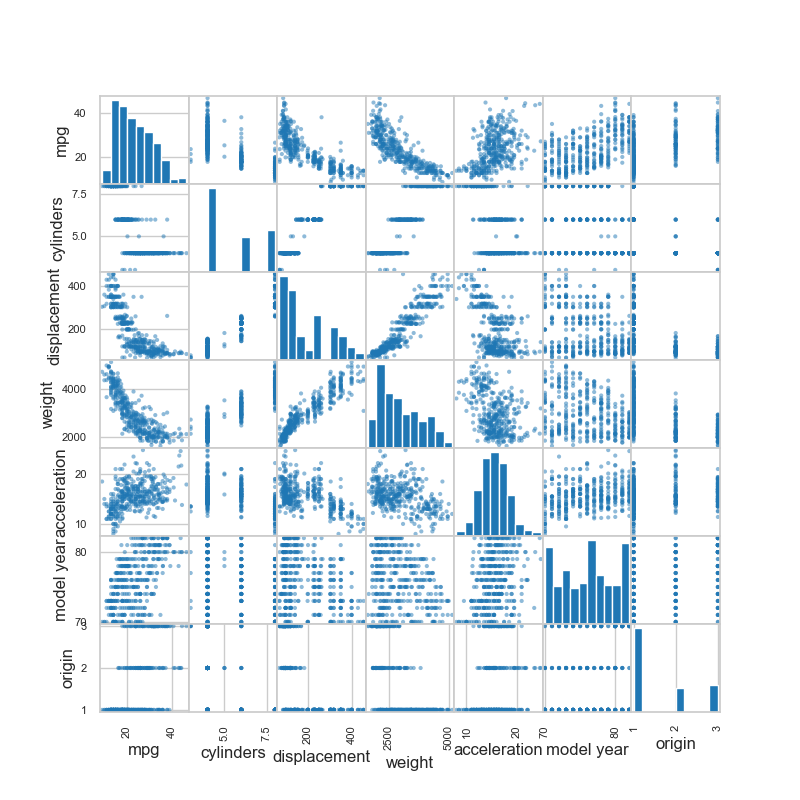

/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5,1,'Auto MPG Scatter Matrix')

In [23]:
from pandas.plotting import scatter_matrix

_, ax = plt.subplots(figsize=(8,8))

axes = scatter_matrix(data, ax=ax)
ax.set_title("Auto MPG Scatter Matrix")

<IPython.core.display.Javascript object>


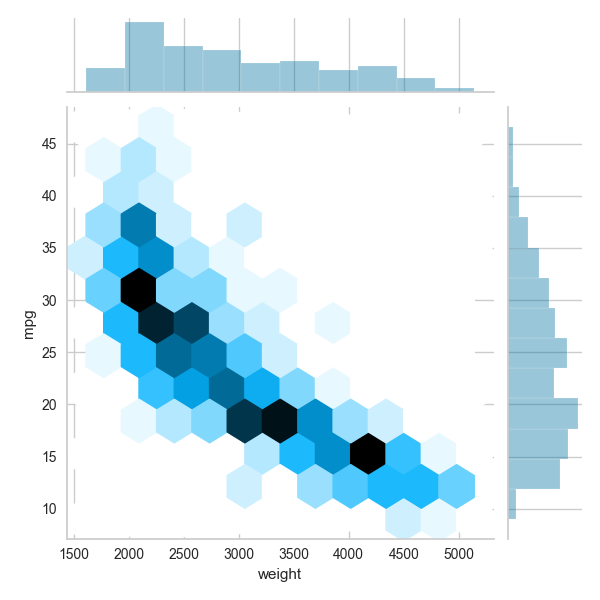

In [31]:
g = sns.jointplot(x='weight', y='mpg', kind='hex', data=data)

In [24]:
from yellowbrick.features import ParallelCoordinates, RadViz

<IPython.core.display.Javascript object>


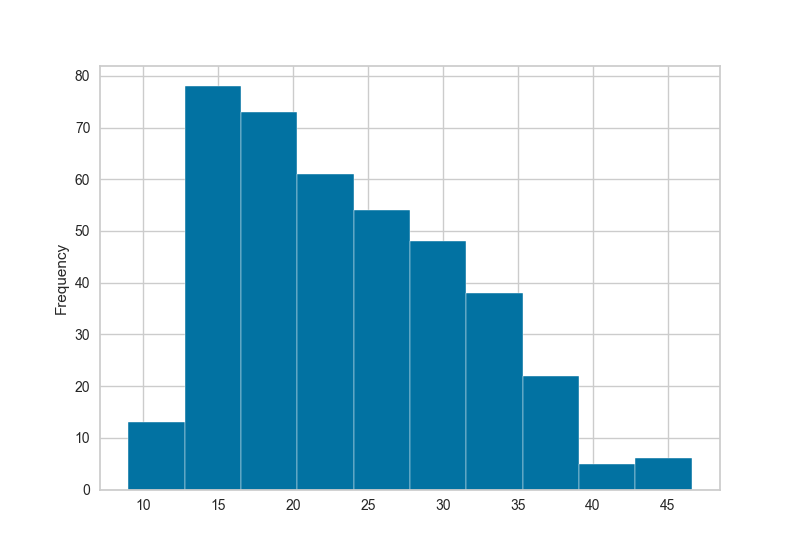

In [27]:
y.plot(kind='hist')

In [32]:
def make_classifier(yi):
    if yi > 30:
        return "high"
    if yi < 20:
        return "low"
    return "medium"
    
yc = pd.Series([make_classifier(yi) for yi in y], index=y.index)

In [48]:
help(ParallelCoordinates)

Help on class ParallelCoordinates in module yellowbrick.features.pcoords:

class ParallelCoordinates(yellowbrick.features.base.DataVisualizer)
 |  Parallel coordinates displays each feature as a vertical axis spaced
 |  evenly along the horizontal, and each instance as a line drawn between
 |  each individual axis. This allows you to detect braids of similar instances
 |  and separability that suggests a good classification problem. 
 |  
 |  Parameters
 |  ----------
 |  
 |  ax : matplotlib Axes, default: None
 |      The axis to plot the figure on. If None is passed in the current axes
 |      will be used (or generated if required).
 |  
 |  features : list, default: None
 |      a list of feature names to use
 |      If a DataFrame is passed to fit and features is None, feature
 |      names are selected as the columns of the DataFrame.
 |  
 |  classes : list, default: None
 |      a list of class names for the legend
 |      If classes is None and a y value is passed to fit then

<IPython.core.display.Javascript object>


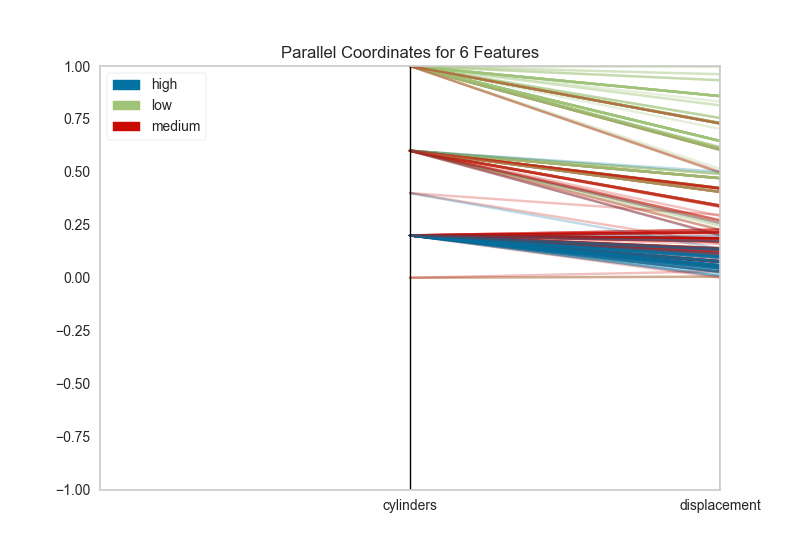

In [53]:
oz = ParallelCoordinates(normalize='minmax')
oz.fit_transform(X, yc) 
oz.poof()

In [55]:
oz = RadViz()
oz.fit_transform(X, yc)
oz.poof()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''